In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

## Testing effect of scale

In [19]:
df = pd.read_csv('csvs/testing.csv')

In [20]:
df.head()

,Unnamed: 0,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,0,200.0,0.001000,100.0,0.014182,0.000200,70.965206,29.984037,0.0,29.990132,0.116455,59.668233,59.680364,0.502513,1.000141,0.159291,0.160614,0.991840
1,1,200.0,0.001000,200.0,0.014182,0.000199,71.253745,59.968073,0.0,59.887231,0.222645,59.668233,59.587795,1.005025,1.001667,0.159291,0.160400,0.993152
2,2,200.0,0.001000,400.0,0.014182,0.000200,71.059946,119.936146,0.0,120.065863,0.505163,59.668233,59.732767,2.010050,0.999322,0.159291,0.160426,0.992984
3,3,200.0,0.001551,100.0,0.014182,0.000482,29.449322,29.984037,0.0,30.053777,0.173707,59.668233,59.807016,0.502513,0.998435,0.159291,0.162278,0.981744
4,4,200.0,0.001551,200.0,0.014182,0.000479,29.626519,59.968073,0.0,59.987236,0.329787,59.668233,59.687300,1.005025,1.000373,0.159291,0.162432,0.980830


In [21]:
list = (df['Signal_Power'] / df['Scale_Param']).values

In [22]:
set(list)

{3.5454017756941e-05, 7.0908035513882e-05, 0.000141816071027764}

In [23]:
df['Signal_to_scale'] = df['Signal_Power'] / df['Scale_Param']

In [24]:
df['Signal_to_scale'].unique() / min(df['Signal_to_scale'].unique())

array([4., 2., 1.])

In [29]:
scale_values = df['Scale_Param'].unique()

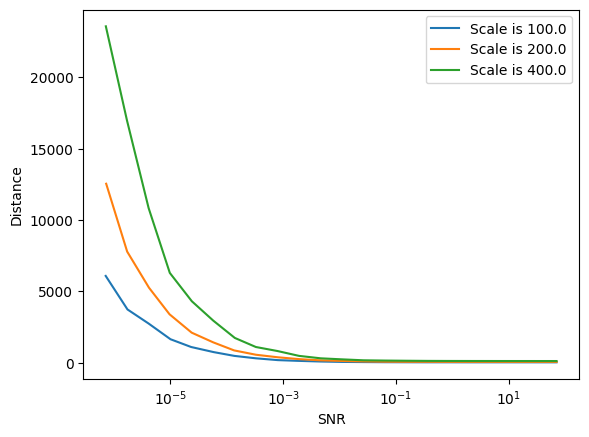

In [30]:
d = {}
for scale in scale_values:
    df_subset = df[df['Scale_Param'] == scale]
    plt.plot(df_subset['SNR'], df_subset['Distances_Noised'], label=f'Scale is {scale}')
    d[scale] = df_subset['Distances_Noised'].values
plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('Distance')
plt.legend()
plt.show()

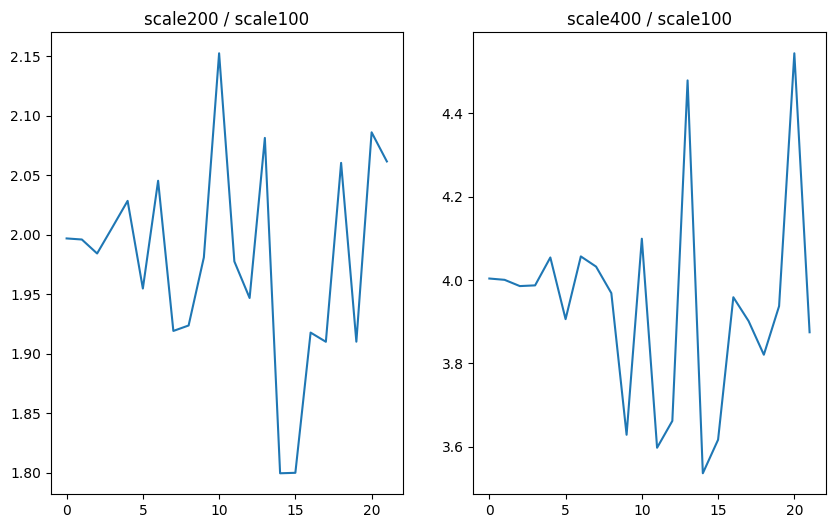

In [31]:
fig = plt.figure(figsize=(10,6))

fig.add_subplot(1,2,1)
plt.title('scale200 / scale100')
plt.plot(d[200] / d[100])

fig.add_subplot(1,2,2)
plt.title('scale400 / scale100')
plt.plot(d[400] / d[100])

Seeing this, I think it should make sense to use scale=1, just so we don't get too much problems with high values. Not sure why I used such high scale values so far.
We can use it since we can see that increasing the scale times X is the same as increasing the distance by X. Therefore, we don't mind using the same scale for all samples. - 24/10

## EMD between Gaussians

Try to add an estimation of how the function we see

In [3]:
df = pd.read_csv('csvs/results_measures_SNR_test.csv')

In [4]:
unique_res = df['Res'].unique()

In [12]:
def interactive_distance(index):
    param = resolutions[index]
    df_subset = df[(df['Res'] == unique_res[index]) & (df['SNR'] > 0.1)]
    plt.figure(figsize=(10, 6))

    x = 1 / df_subset['SNR'].values
    y_noised = df_subset['Distances_Noised'].values
    y_classic = df_subset['Distances_Classic'].values

    a,b = np.polyfit(x, y_noised, 1)
    approx = a * x + b
    
    plt.plot(x, y_noised, label='Distance')
    plt.plot(x, approx, label='Fitted Log funcion')
    plt.plot(x, y_classic, label='Distance between measures without noise')
    plt.title(f'Resolution is {param}')
    plt.xlabel('1 / SNR')
    plt.legend()
    plt.show()

In [13]:
resolutions= df['Res'].unique()

In [14]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(resolutions) - 1,
    step=1,
    description='Noise Index:',
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '470px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=4), Output(l…

In [15]:
def interactive_distance(index):
    param = resolutions[index]
    df_subset = df[(df['Res'] == unique_res[index]) & (df['SNR'] > 0.001)]
    plt.figure(figsize=(10, 6))

    x = 1 / df_subset['SNR'].values
    sqrt_x = np.sqrt(x)
    y_distances_linear_noised = df_subset['Distances_Linear_Noised'].values
    y_distances_linear_classic = df_subset['Distances_Linear'].values

    a, b = np.polyfit(sqrt_x, y_distances_linear_noised, 1)
    approx = a * np.sqrt(x) + b
    
    plt.plot(x, y_distances_linear_classic, label='L2')
    plt.plot(x, y_distances_linear_noised, label='L2 Noised')
    plt.plot(x, approx, label='Approximation using sqrt')    
    plt.title(f'Resolution is {param}')
    plt.xlabel('1 / SNR')
    plt.legend()
    plt.show()

In [16]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(resolutions) - 1,
    step=1,
    description='Noise Index:', 
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=4), Output(l…

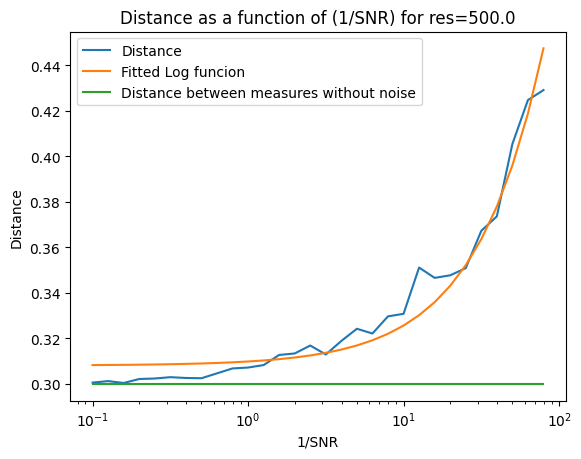

In [18]:
res_index = 4

df_subset = df[(df['Res'] == unique_res[res_index]) & (df['SNR'] > 0.01)]

x = 1 / df_subset['SNR'].values
# x = df_subset['SNR'].values
y_noised = df_subset['Distances_Noised']
y_classic = df_subset['Distances_Classic']

x_log = np.log(x)

#Polynomial of degree 1
a, b = np.polyfit(x, y_noised, 1)
approx = a * x + b

# Polynomial of degree 2
# a, b, c = np.polyfit(x_log, y_noised, 2)
# approx = a * (x_log ** 2) + b * x_log + c

plt.plot(x, y_noised, label='Distance')
plt.plot(x, approx, label='Fitted Log funcion')
plt.plot(x, y_classic, label='Distance between measures without noise')
# print(1 / df_subset['SNR'].values)
plt.legend()
plt.title(f'Distance as a function of (1/SNR) for res={unique_res[res_index]}')
plt.xlabel('1/SNR')
plt.ylabel('Distance')
plt.xscale('log')

In [19]:
df_subset.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
125,500.0,0.029975,1.0,0.005656,0.451953,0.012589,0.299831,8.134986e-18,0.429193,0.024502,149.615909,214.167518,0.002004,0.817569,0.100594,0.953439,0.105623
126,500.0,0.026715,1.0,0.005656,0.356000,0.015849,0.299831,8.134986e-18,0.424811,0.025033,149.615909,211.980912,0.002004,0.831640,0.100594,0.847316,0.118844
127,500.0,0.023810,1.0,0.005656,0.286687,0.019953,0.299831,8.134986e-18,0.405497,0.021176,149.615909,202.342930,0.002004,0.844646,0.100594,0.761065,0.132302
128,500.0,0.021221,1.0,0.005656,0.225508,0.025119,0.299831,8.134986e-18,0.373674,0.019434,149.615909,186.463522,0.002004,0.916515,0.100594,0.678141,0.148467
129,500.0,0.018913,1.0,0.005656,0.179422,0.031623,0.299831,8.134986e-18,0.367313,0.018095,149.615909,183.288990,0.002004,0.921301,0.100594,0.608157,0.165573


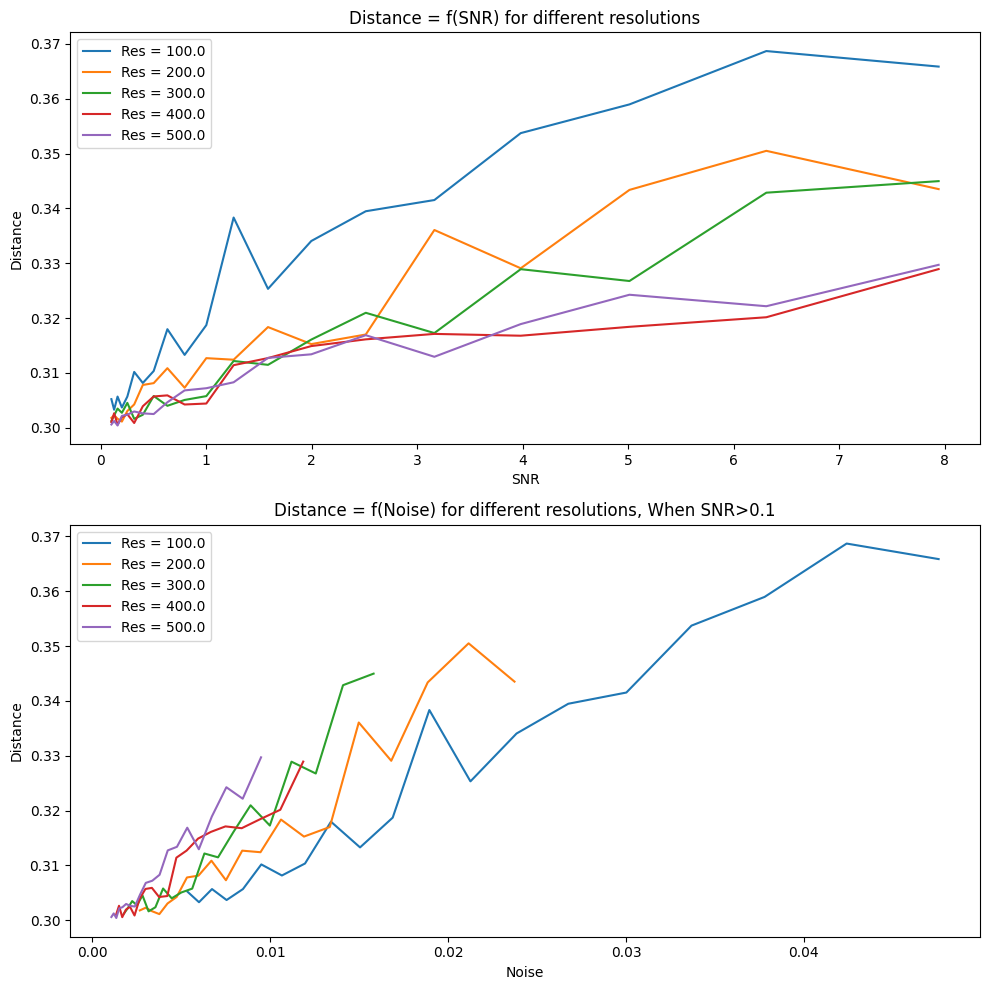

In [20]:
d = {}
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for res in unique_res:
    df_subset = df[(df['Res'] == res) & (df['SNR'] > 0.1)]
    
    x_values_SNR = 1 / df_subset['SNR'].values
    x_values_noise = df_subset['Noise_Param'].values
    y_noised = df_subset['Distances_Noised'].values
    y_distances_linear_noised = df_subset['Distances_Linear_Noised'].values
    y_distances_linear_classic = df_subset['Distances_Linear'].values
    
    ax1.plot(x_values_SNR, y_noised, label=f'Res = {res}')
    d[res] = df_subset['Distances_Noised'].values
    ax2.plot(x_values_noise, y_noised, label=f'Res = {res}')
    ax2.plot



# ax1.set_xscale('log')
# ax1.invert_xaxis()
ax1.set_title('Distance = f(SNR) for different resolutions')
ax1.set_xlabel('SNR')
ax1.set_ylabel('Distance')
ax1.legend()

# ax2.set_xscale('log')
ax2.set_title('Distance = f(Noise) for different resolutions, When SNR>0.1')
ax2.set_xlabel('Noise')
ax2.set_ylabel('Distance')
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
len(d[100])

20

In [22]:
len(d[500])

20

In [23]:
df.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,100.0,0.168835,1.0,0.028505,2.858620,0.010000,0.299855,8.134986e-18,0.855915,0.055122,29.685607,84.735619,0.010101,0.420477,0.225836,2.394460,0.094818
1,100.0,0.150474,1.0,0.028505,2.246626,0.012589,0.299855,8.134986e-18,0.770321,0.049864,29.685607,76.261759,0.010101,0.457754,0.225836,2.159523,0.105055
2,100.0,0.134111,1.0,0.028505,1.824335,0.015849,0.299855,8.134986e-18,0.663291,0.044132,29.685607,65.665845,0.010101,0.537222,0.225836,1.908501,0.118928
3,100.0,0.119526,1.0,0.028505,1.444216,0.019953,0.299855,8.134986e-18,0.600580,0.035085,29.685607,59.457443,0.010101,0.582253,0.225836,1.701347,0.133448
4,100.0,0.106528,1.0,0.028505,1.113495,0.025119,0.299855,8.134986e-18,0.561797,0.034055,29.685607,55.617926,0.010101,0.623168,0.225836,1.507276,0.150626


In [24]:
len(df.index)

155

In [25]:
SNR_values = df['SNR'].unique()

In [26]:
len(SNR_values)

31

In [69]:
approximated_distances_df = pd.DataFrame()
scales = df['Scale_Param'].unique()
scale = scales[0]

for res in unique_res:
    df_subset = df[(df['Res'] == res) & (df['Scale_Param']==scale) & (df['SNR'] > 0.000001)]
    # print(len(relevant_row.index))
       
    x = 1 / df_subset['SNR'].values
    y_noised = df_subset['Distances_Noised']
    for SNR in SNR_values:
        a, b = np.polyfit(x, y_noised, 1)

        relevant_row = df_subset[df_subset['SNR'] == SNR]
        approx = a * (1/relevant_row['SNR']) + b
        classic_distance = relevant_row['Distances_Classic'].values
        noised_distance = relevant_row['Distances_Noised'].values 

        new_row = {
            'Scale' : scale,
            'Res' : res,
            'Noise' : relevant_row['Noise_Param'].values[0],
            'SNR' : relevant_row['SNR'].values[0],
            'Distance_Without_Noise' : classic_distance[0],
            'Distance_With_Noise' : noised_distance[0],
            'Distance_With_Noise_Bound' : approx.values[0],
            'Ratio' : (noised_distance / approx).values[0]
        }
            
        approximated_distances_df = approximated_distances_df._append(new_row, ignore_index=True)

In [70]:
len(approximated_distances_df.index)

155

In [71]:
len(df_subset.index)

31

Text(0, 0.5, 'SNR')

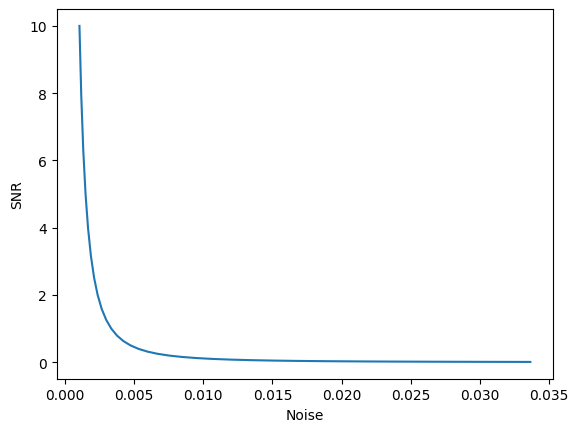

In [72]:
plt.plot(df_subset['Noise_Param'], df_subset['SNR'].values)
plt.xlabel('Noise')
plt.ylabel('SNR')
#plt.xscale('log')

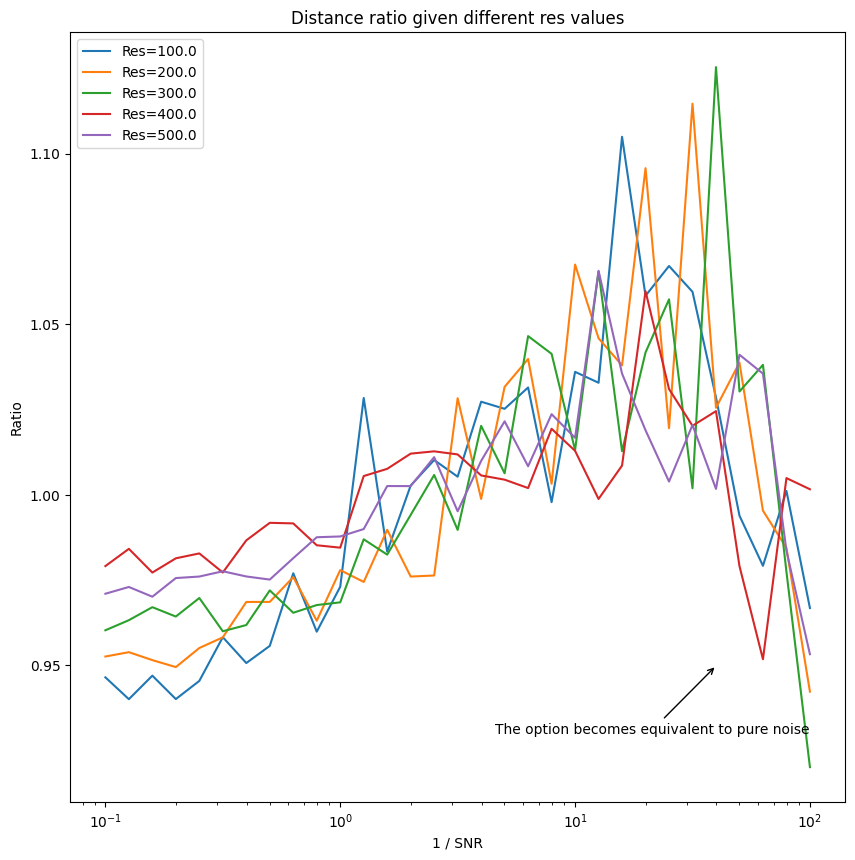

In [73]:
plt.figure(figsize=(10,10))

for i in range(5):
    subset = approximated_distances_df[approximated_distances_df['Res'] == resolutions[i]]
    # x = subset['SNR'].values
    x = 1 / subset['SNR'].values
    plt.plot(x, subset['Ratio'],
         label = f'Res={resolutions[i]}')
plt.title('Distance ratio given different res values')
plt.xscale('log')
plt.xlabel('1 / SNR')
plt.ylabel('Ratio')
plt.annotate('The option becomes equivalent to pure noise', xy=(40, 0.95), xytext = (100, 0.93), arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.legend()
plt.show()

In [74]:
approximated_distances_df.head()

,Scale,Res,Noise,SNR,Distance_Without_Noise,Distance_With_Noise,Distance_With_Noise_Bound,Ratio
0,1.0,100.0,0.168835,0.010000,0.299855,0.855915,0.885295,0.966813
1,1.0,100.0,0.150474,0.012589,0.299855,0.770321,0.769423,1.001167
2,1.0,100.0,0.134111,0.015849,0.299855,0.663291,0.677382,0.979198
3,1.0,100.0,0.119526,0.019953,0.299855,0.600580,0.604271,0.993892
4,1.0,100.0,0.106528,0.025119,0.299855,0.561797,0.546197,1.028561


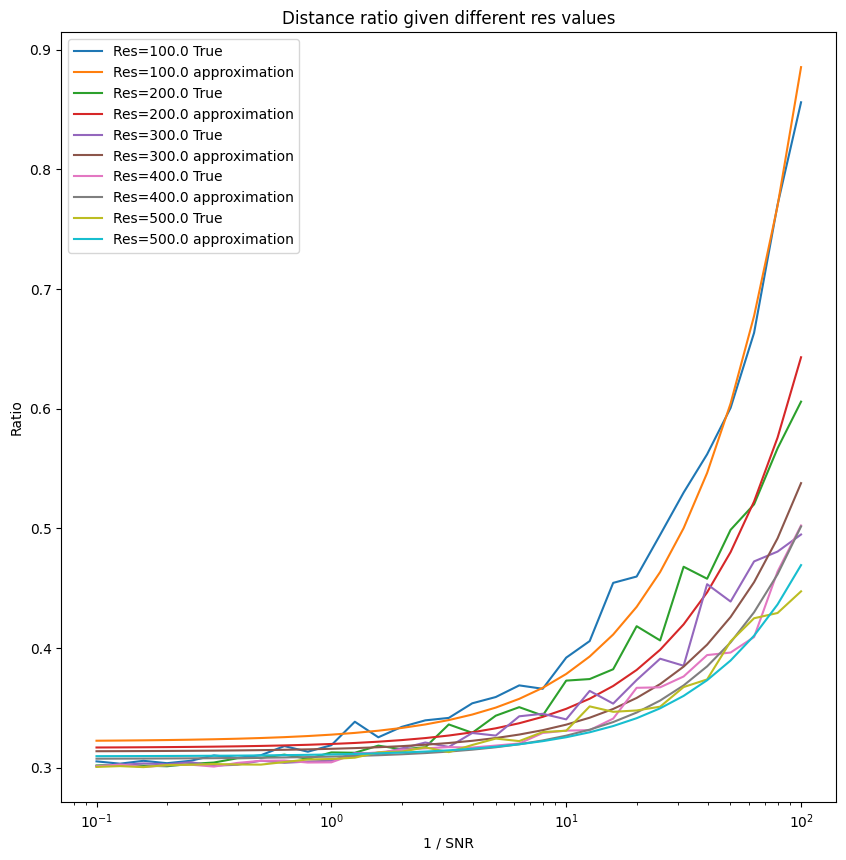

In [78]:
plt.figure(figsize=(10,10))

for i in range(5):
    
    subset = approximated_distances_df[approximated_distances_df['Res'] == resolutions[i]]
    # x = subset['SNR'].values
    x = 1 / subset['SNR'].values
    plt.plot(x, subset['Distance_With_Noise'], label=f'Res={resolutions[i]} True')
    plt.plot(x, subset['Distance_With_Noise_Bound'], label=f'Res={resolutions[i]} approximation')

plt.title('Distance ratio given different res values')
plt.xscale('log')
plt.xlabel('1 / SNR')
plt.ylabel('Ratio')
plt.annotate('The option becomes equivalent to pure noise', xy=(40, 0.95), xytext = (100, 0.93), arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.legend()
plt.show()

Higher 1/SNR means the SNR is low and the option becomes equivalent to pure noise

lower 1/SNR means SNR is high, Thus meaning the noise is not significant and therefore we get some plateau

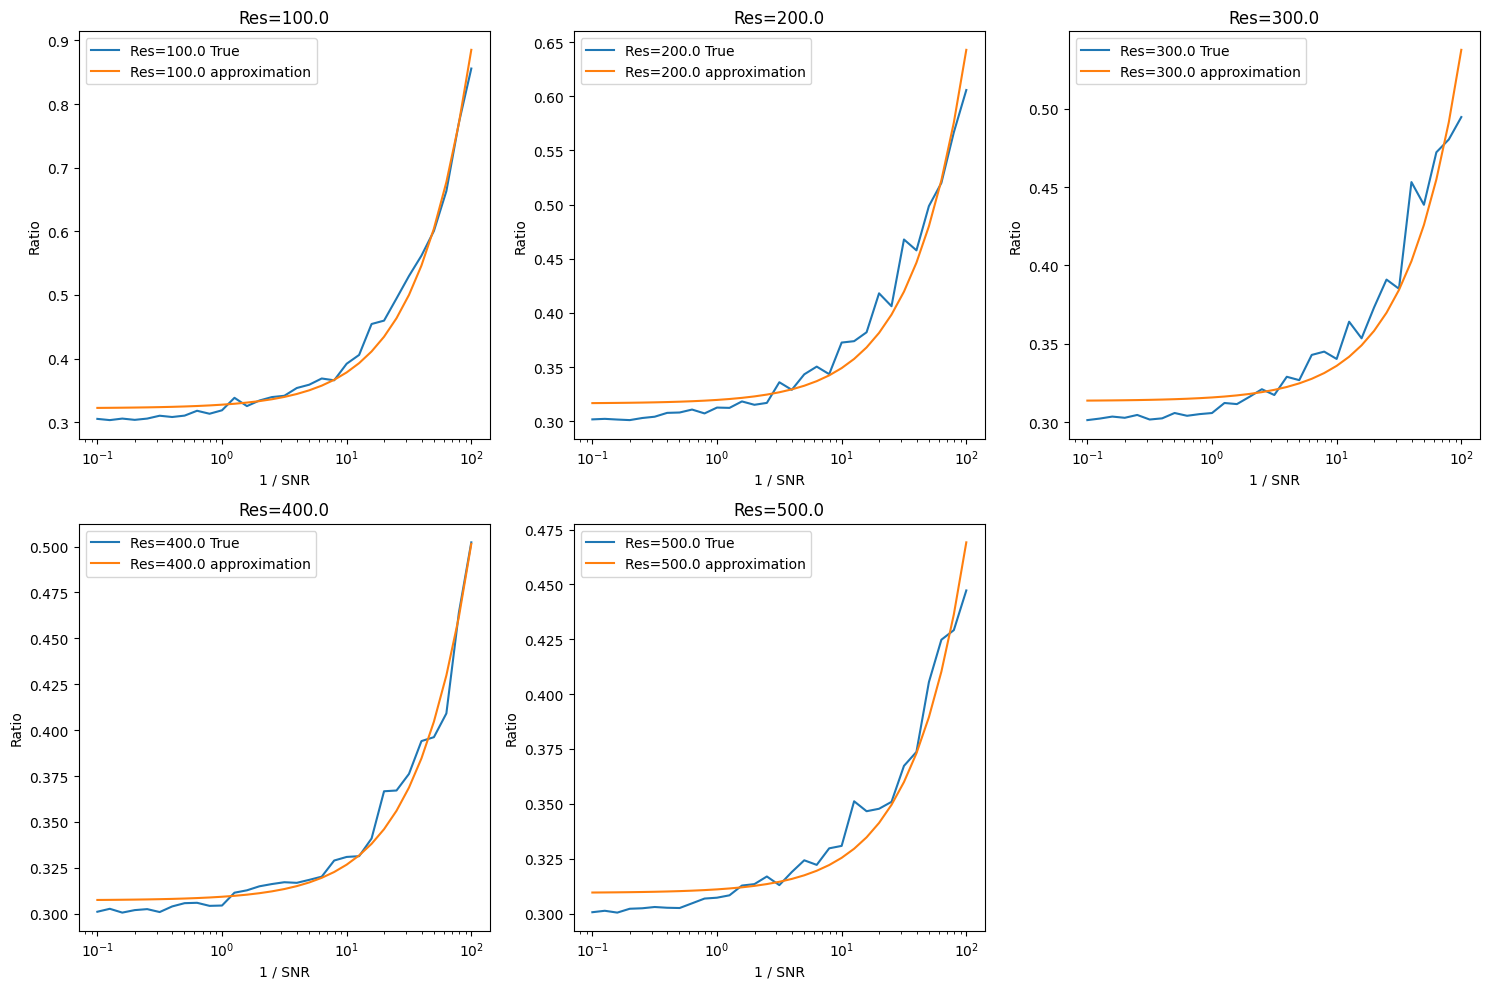

In [81]:
plt.figure(figsize=(15, 10)) 

for i in range(len(resolutions)):
    
    subset = approximated_distances_df[approximated_distances_df['Res'] == resolutions[i]]
    x = 1 / subset['SNR'].values
    
    # Arrange the plots in a 2x3 grid
    plt.subplot(2, 3, i + 1)
    
    plt.plot(x, subset['Distance_With_Noise'], label=f'Res={resolutions[i]} True')
    plt.plot(x, subset['Distance_With_Noise_Bound'], label=f'Res={resolutions[i]} approximation')
    plt.title(f'Res={resolutions[i]}')
    plt.xscale('log')
    plt.xlabel('1 / SNR')
    plt.ylabel('Ratio')
    
    # Annotate each subplot
    plt.annotate('The option becomes equivalent to pure noise', xy=(35000, 0.93), xytext = (20000, 0.93), arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='right')
    
    plt.legend()

plt.tight_layout()  # Adjusts the plots so that they don't overlap
plt.show()

In [37]:
n = 1000
x = np.random.normal(0,3,n)

In [38]:
sum(x ** 2)

9087.081201895002